In [1]:
!curl https://download.mosek.com/stable/8.1.0.82/mosektoolslinux64x86.tar.bz2 --output /root/mosektoolslinux64x86.tar.bz2
!cd /root/; tar xvf /root/mosektoolslinux64x86.tar.bz2
from google.colab import drive
drive.mount('/content/gdrive')
!cp -avr /content/gdrive/My\ Drive/EE6332/mosek.lic /root/mosek/
!pip install git+https://github.com/convexengineering/gpkit
!pip show gpkit

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40.3M  100 40.3M    0     0  33.9M      0  0:00:01  0:00:01 --:--:-- 34.0M
mosek/8/tools/examples/python/parameters.py
mosek/8/toolbox/examples/cqo1.m
mosek/8/toolbox/r2014a/mskqpopt.m
mosek/8/tools/examples/fusion/java/breaksolver.java
mosek/8/toolbox/r2014a/mskcheck.m
mosek/8/tools/examples/fusion/cxx/lo1.cc
mosek/8/tools/examples/data/dgo.f
mosek/8/tools/examples/dotnet/scopt1.cs
mosek/8/tools/examples/dotnet/solvebasis.cs
mosek/8/toolbox/r2014aom/mskerrmsg.m
mosek/8/toolbox/examples/simple.m
mosek/8/tools/examples/java/solutionquality.java
mosek/8/tools/examples/fusion/dotnet/production.cs
mosek/8/tools/examples/fusion/java/Makefile
mosek/8/tools/examples/fusion/python/lo1.py
mosek/8/tools/examples/fusion/java/duality.java
mosek/8/tools/platform/linux64x86/bin/libcilkrts.so.5
mosek/8/toolbox/examples/qo2.m
mosek/8/tools/ex

In [2]:
from pylab import *
from gpkit import VectorVariable, Variable, Model, units

Found no installed solvers, beginning a build.
# Building GPkit version 1.1
# Moving to the directory from which GPkit was imported.

Attempting to find and build solvers:

# Looking for `mosek_cli`
#   (A "success" is if mskexpopt complains that
#    we haven't specified a file for it to open.)
#     Calling 'mskexpopt'
##
### CALL BEGINS
### CALL ENDS
##
# Looks like `mskexpopt` was not found in the default PATH,
#  so let's try locating that binary ourselves.
#   Adding /root/mosek/8/tools/platform/linux64x86/bin to the PATH
#     Calling 'mskexpopt'
##
### CALL BEGINS
### CALL ENDS
##

Found mosek_cli in /root/mosek/8/tools/platform/linux64x86/bin

# Looking for `mosek_conif`
#   Trying to import mosek...
# Did not find
# mosek_conif

# Looking for `cvxopt`
#   Trying to import cvxopt...


.


Found cvxopt in the default PYTHONPATH

Found the following solvers: mosek_cli, cvxopt
#     Replacing directory env


.........................E...................................................................................................................................../usr/local/lib/python3.11/dist-packages/gpkit/constraints/sgp.py:177: UserWarning: SGP not convergent: Cost rose by 0.0099% (9.99901e-31 to 1e-30) on GP solve 2. Details can be found in `m.program.results` or by solving at a higher verbosity. Note convergence is not guaranteed for models with SignomialEqualities.
  pywarnings.warn(
.................................................
ERROR: test_vector_sweep (gpkit.tests.t_sub.TestModelSubs.test_vector_sweep)
Test sweep involving VectorVariables
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gpkit/tests/t_sub.py", line 205, in test_vector_sweep
    sol = m.solve(verbosity=0)
          ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gpkit/constraints/prog_fa


GPkit is now installed with solver(s) ['mosek_cli', 'cvxopt']
To incorporate new solvers at a later date, run `gpkit.build()`.

If any tests didn't pass, please post the output above
(starting from "Found no installed solvers, beginning a build.")
to gpkit@mit.edu or https://github.com/convexengineering/gpkit/issues/new
so we can prevent others from having these errors.

The same goes for any other bugs you encounter with GPkit:
send 'em our way, along with any interesting models, speculative features,
comments, discussions, or clarifications you feel like sharing.

Finally, we hope you find our documentation (https://gpkit.readthedocs.io/)
and engineering-design models (https://github.com/convexengineering/gplibrary/)
to be useful resources for your own applications.

Enjoy!



### Required Classes for the Project

In [3]:
import re
from collections import defaultdict, deque

class Gate:
    def __init__(self, gate_type, name, output, inputs):
        self.name = name
        self._type = gate_type
        self.output = output
        self.inputs = inputs
        self.logical_effort = self.compute_logical_effort()
        self.parasitic_effort = self.compute_parasitic_effort()
        self.input_cap = self.compute_input_capacitance()  # Corrected: now called after setting needed fields


    def compute_logical_effort(self):
        # Logical effort for different gates based on the number of inputs (fan-in)
        le_dict = {'NAND': {2: 4/3, 3: 5/3, 4: 2},'NOR': {2: 5/3, 3: 7/3, 4: 3},'NOT': {1: 1},}

        # Check the number of inputs for the gate and return the appropriate logical effort
        gate_type = self._type.upper()
        num_inputs = len(self.inputs)

        if gate_type in le_dict and num_inputs in le_dict[gate_type]:
            return le_dict[gate_type][num_inputs]
        return 1  # Default for undefined gate types

    def compute_parasitic_effort(self):
        return len(self.inputs)

    def compute_input_capacitance(self):
        return 3*self.compute_logical_effort()

    def get_primary_input_to_gate_map(self):
        input_to_gates = defaultdict(list)
        primary_inputs = self.find_primary_inputs()
        for inp in primary_inputs:
            if inp in self.reverse_graph:
                for out_node in self.reverse_graph[inp]:
                    gate = self.node_to_gate.get(out_node)
                    if gate:
                        input_to_gates[inp].append(gate)
        return dict(input_to_gates)

    def __repr__(self):
        return (f"Gate(name={self.name}, type={self._type}, output={self.output}, "
                f"inputs={self.inputs}, LE={self.logical_effort}, PE={self.parasitic_effort})")

In [4]:
class VerilogParser:
    def __init__(self, verilog_code):
        self.graph = defaultdict(list)
        self.reverse_graph = defaultdict(list)
        self.nodes = set()
        self.node_to_gate = {}
        self.gate_type = {}
        self.gates = {}  # New: name -> Gate instance
        self.parse_verilog(verilog_code)

    def parse_verilog(self, verilog_code):
        lines = [line.strip() for line in verilog_code.strip().splitlines() if line.strip()]
        gate_pattern = re.compile(r'(nand|nor|not)\s+(\w+)\s*\(([^)]+)\);')

        for line in lines:
            match = gate_pattern.match(line)
            if match:
                gate_type, gate_name, pin_list = match.groups()
                pins = [pin.strip() for pin in pin_list.split(',')]
                output = pins[0]
                inputs = pins[1:]

                self.node_to_gate[output] = gate_name
                self.gate_type[gate_name] = gate_type
                self.gates[gate_name] = Gate(gate_type, gate_name, output, inputs)

                self.nodes.add(output)
                self.graph[output].extend(inputs)
                for inp in inputs:
                    self.reverse_graph[inp].append(output)
                    self.nodes.add(inp)

    def find_primary_outputs(self):
        return [node for node in self.nodes if node not in self.reverse_graph]

    def find_primary_inputs(self):
        return [node for node in self.nodes if node not in self.graph]

    def print_fanout_list(self):
        fanout_list = defaultdict(list)
        for output_node, gate_name in self.node_to_gate.items():
            if output_node in self.reverse_graph:
                for fanout_node in self.reverse_graph[output_node]:
                    if fanout_node in self.node_to_gate:
                        fanout_list[gate_name].append(self.node_to_gate[fanout_node])
        return {gate: ', '.join(fanouts) for gate, fanouts in fanout_list.items() if fanouts}

    def get_all_gates(self):
        return list(self.gates.keys())

    def get_primary_inputs(self):
        return [n for n in self.graph.nodes if not self.graph.nodes[n]['inputs']]  # Buggy

    def get_fanout_dict(self):
        fanout_dict = {gate: [] for gate in self.gates}
        for gate, gate_obj in self.gates.items():
            for inp in gate_obj.inputs:
                if inp in self.gates:
                    fanout_dict[inp].append(gate)
        return fanout_dict


### Finding the Twall of the circuit

In [18]:
from gpkit import Variable, VectorVariable, Model

def optimize_critical_path_delay(parser):
    gate_nodes = parser.get_all_gates()

    # Fix: ensure fanout_dict has no empty strings
    fanout_dict_raw = parser.print_fanout_list()
    fanout_dict = {
        gate: [fout for fout in fanouts.split(', ') if fout]
        for gate, fanouts in fanout_dict_raw.items()
    }

    g = [parser.gates[gate].logical_effort for gate in gate_nodes]
    p = [parser.gates[gate].parasitic_effort for gate in gate_nodes]
    input_cap = [parser.gates[gate].input_cap for gate in gate_nodes]
    primary_inputs = parser.find_primary_inputs()
    pog = []
    # Build graph-like structure for inputs
    graph = {gate: {'inputs': parser.gates[gate].inputs} for gate in gate_nodes}

    N = len(gate_nodes)
    Gsize = VectorVariable(N, 'x')
    T = VectorVariable(N, 'T')

    C_load_size = 1000
    C_load = 3 * C_load_size
    tau = 5
    max_gate_size = 64

    constraints, gate_index = [], {gate: idx for idx, gate in enumerate(gate_nodes)}
    fanout_caps = []
    fanin_indices = {gate: [] for gate in gate_nodes}

    # Calculate fanout capacitance for each gate
    for i, gate in enumerate(gate_nodes):
        fanouts = fanout_dict.get(gate, [])
        if fanouts:
            cap = sum(
                parser.gates[fout].input_cap * Gsize[gate_index[fout]]
                for fout in fanouts if fout in gate_index
            )
        else:
            cap = C_load
            pog.append(gate)
        fanout_caps.append(cap)

    # Build fanin indices
    for gate, fanouts in fanout_dict.items():
        for fout in fanouts:
            if fout in fanin_indices:
                fanin_indices[fout].append(gate)

    # Delay and timing constraints
    delays = []
    for i, gate in enumerate(gate_nodes):
        delay = (g[i] * fanout_caps[i] / (input_cap[i] * Gsize[i])) + p[i]
        delays.append(delay)
        if fanin_indices[gate]:
            for fanin in fanin_indices[gate]:
                constraints.append(T[i] >= T[gate_index[fanin]] + delay)
        else:
            constraints.append(T[i] >= delay)  # No fanins

    # Primary input shared load constraint
    max_pi_load = 150
    pi_to_gates = {pi: [] for pi in primary_inputs}
    for gate in gate_nodes:
        for inp in graph[gate]['inputs']:
            if inp in pi_to_gates:
                pi_to_gates[inp].append(gate)

    for pi, gates in pi_to_gates.items():
        if gates:
            total_load = sum(parser.gates[g].input_cap * Gsize[gate_index[g]] for g in gates)
            constraints.append(total_load <= max_pi_load)

    # Gate size bounds
    for i in range(N):
        constraints.append(Gsize[i] >= 1)
        constraints.append(Gsize[i] <= max_gate_size)

    # Tmax constraints (for gates with no fanouts)
    final_outputs = [i for i, gate in enumerate(gate_nodes) if not fanout_dict.get(gate)]
    Tmax = Variable("Tmax")
    for i in final_outputs:
        constraints.append(Tmax >= T[i])

    # Solve the model
    m = Model(Tmax, constraints)
    sol = m.solve(verbosity=1)

    Tmax_val = sol["variables"]["Tmax"]
    Tmax_ps = Tmax_val * tau
    sizes = {gate_nodes[i]: float(sol["variables"]["x"][i]) for i in range(N)}
    arrival_times = {gate_nodes[i]: float(sol["variables"]["T"][i]) for i in range(N)}

    return Tmax_val, Tmax_ps, sizes, arrival_times, pog


### Execution of 1st question

In [143]:
# Sample Usage
filename = "c1908.txt"
with open(filename, 'r') as file:
    verilog_code = file.read()

# Process each file

print(f"Processing: {filename}")
parser = VerilogParser(verilog_code)
print("Primary Inputs:", parser.find_primary_inputs())
print("Primary Outputs:", parser.find_primary_outputs())
print("Fanout List:", parser.print_fanout_list())
all_gates = parser.get_all_gates()
print("All gates:", all_gates)
Tmax_val, Tmax_ps, sizes, arrival_times, PoG= optimize_critical_path_delay(parser)
Tmax_val = round(Tmax_val,2)
print(f"Tmax (normalized): {Tmax_val}")
print(f"Tmax (ps): {Tmax_ps}")
print("Gate sizes:", sizes)
print("Arrival times:", arrival_times)

Processing: c1908.txt
Primary Inputs: ['N13', 'N63', 'N1', 'N66', 'N22', 'N76', 'N60', 'N7', 'N4', 'N37', 'N88', 'N19', 'N104', 'N34', 'N16', 'N43', 'N85', 'N99', 'N56', 'N69', 'N46', 'N28', 'N94', 'N31', 'N49', 'N91', 'N72', 'N25', 'N82', 'N40', 'N53', 'N10', 'N79']
Primary Outputs: ['N2753', 'N2891', 'N2767', 'N2899', 'N2889', 'N2762', 'N2892', 'N2887', 'N2756', 'N2886', 'N2785', 'N2783', 'N2787', 'N2782', 'N2784', 'N2768', 'N2786', 'N2890', 'N2755', 'N2779', 'N2811', 'N2781', 'N2780', 'N2888', 'N2754']
Fanout List: {'NOT1_1': 'NOT1_48, NOT1_95, NOT1_97', 'NOT1_2': 'NOT1_50, NOT1_100', 'NOT1_3': 'NOT1_66, NOT1_102', 'NAND2_4': 'NAND2_46', 'NOT1_5': 'NAND2_12', 'NOT1_6': 'NAND2_13', 'NOT1_7': 'NAND2_19', 'NAND2_8': 'NAND2_28', 'NAND2_9': 'NAND2_20', 'NAND2_10': 'NAND2_21', 'NAND2_11': 'NAND2_22', 'NAND2_12': 'NAND2_23', 'NAND2_13': 'NAND2_24', 'NAND2_14': 'NAND2_40', 'NAND2_15': 'NAND2_33', 'NOT1_16': 'NAND2_25', 'NAND2_17': 'NAND2_41', 'NOT1_18': 'NAND2_27', 'NAND2_19': 'NAND2_28', '

<ipython-input-18-f81d9c08a3e1>:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  cap = sum(
<ipython-input-18-f81d9c08a3e1>:74: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_load = sum(parser.gates[g].input_cap * Gsize[gate_index[g]] for g in gates)


Using solver 'mosek_cli'
 for 2289 free variables
  in 3969 posynomial inequalities.
Solving took 0.934 seconds.
Tmax (normalized): 177.58
Tmax (ps): 887.9237857352372
Gate sizes: {'NOT1_1': 36.680416416162174, 'NOT1_2': 48.9998873927087, 'NOT1_3': 31.655123011692783, 'NAND2_4': 5.890447670773809, 'NOT1_5': 4.326158648010458, 'NOT1_6': 4.325981279141977, 'NOT1_7': 47.75343492778918, 'NAND2_8': 15.632483109728867, 'NAND2_9': 6.581673208382558, 'NAND2_10': 6.569258732318197, 'NAND2_11': 6.613499904210299, 'NAND2_12': 6.616800864183518, 'NAND2_13': 6.617250821940672, 'NAND2_14': 17.72111736669202, 'NAND2_15': 4.754435634027237, 'NOT1_16': 22.183793505334894, 'NAND2_17': 17.620552915323508, 'NOT1_18': 21.047862267853397, 'NAND2_19': 43.991524923916266, 'NAND2_20': 10.227406205854047, 'NAND2_21': 10.238908273380423, 'NAND2_22': 10.267637925808629, 'NAND2_23': 10.270472184985927, 'NAND2_24': 10.268808503253817, 'NAND2_25': 34.38096265503444, 'NAND2_26': 4.7546210606327595, 'NAND2_27': 32.799

In [129]:
# Write dictionary to a text file
with open('c7552_out.txt', 'w') as f:
    for key, value in sizes.items():
        f.write(f"{key}: {value}\n")

# Download the file to your local system
from google.colab import files
files.download('c7552_out.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
print(sum(list(sizes.values())))

2820.4485853783117


### 2. Area Minimization

In [10]:
from gpkit import Variable, VectorVariable, Model

def optimize_area_for_Tspec(parser, Tmax):
    gate_nodes = parser.get_all_gates()
    gate_index = {gate: i for i, gate in enumerate(gate_nodes)}
    N = len(gate_nodes)

    input_cap = [parser.gates[gate].input_cap for gate in gate_nodes]
    g = [parser.gates[gate].logical_effort for gate in gate_nodes]
    p = [parser.gates[gate].parasitic_effort for gate in gate_nodes]

    fanout_dict_raw = parser.print_fanout_list()
    fanout_dict = {gate: fanouts.split(', ') for gate, fanouts in fanout_dict_raw.items()}

    primary_inputs = parser.find_primary_inputs()
    pi_to_gate = defaultdict(list)
    for gate in gate_nodes:
        for inp in parser.gates[gate].inputs:
            if inp in primary_inputs:
                pi_to_gate[inp].append(gate)

    fanin_indices = {gate: [] for gate in gate_nodes}
    for src, dests in fanout_dict.items():
        for dst in dests:
            fanin_indices[dst].append(src)

    final_outputs = [gate for gate in gate_nodes if not fanout_dict.get(gate)]

    max_pi_load = 150
    max_gate_size = 64
    C_load = 3000
    factors = [1.05, 1.1, 1.2, 1.3, 1.4, 1.5]
    areas = {}

    for factor in factors:
        Tspec = Variable("Tspec", Tmax * factor)
        Gsize = VectorVariable(N, "x")
        T = VectorVariable(N, "T")

        constraints = []

        # Fanout capacitance
        fanout_caps = []
        for i, gate in enumerate(gate_nodes):
            fanouts = fanout_dict.get(gate, [])
            if fanouts:
                cap_expr = sum([input_cap[gate_index[f]] * Gsize[gate_index[f]] for f in fanouts])
                fanout_caps.append(cap_expr)
            else:
                fanout_caps.append(C_load)

        # Gate delay and timing constraints
        for i, gate in enumerate(gate_nodes):
            delay_expr = (g[i] * fanout_caps[i]) / (input_cap[i] * Gsize[i]) + p[i]
            if fanin_indices[gate]:
                for fin in fanin_indices[gate]:
                    constraints.append(T[i] >= T[gate_index[fin]] + delay_expr)
            else:
                constraints.append(T[i] >= delay_expr)

        # Output arrival constraint
        for i, gate in enumerate(gate_nodes):
            if gate in final_outputs:
                constraints.append(T[i] <= Tspec)

        # Primary input drive constraint
        for pi, fanouts in pi_to_gate.items():
            load_expr = sum([input_cap[gate_index[g]] * Gsize[gate_index[g]] for g in fanouts])
            constraints.append(load_expr <= max_pi_load)

        # Size constraints
        for i in range(N):
            constraints.append(Gsize[i] >= 1)
            constraints.append(Gsize[i] <= max_gate_size)

        model = Model(Gsize.sum(), constraints)
        sol = model.solve(verbosity=0)
        areas[factor] = round(float(sol["variables"]["x"].sum()),2)

    return areas


### Execution of 2nd

In [81]:
parser = VerilogParser(verilog_code)
print(Tmax_val)
# Now optimize
areas = optimize_area_for_Tspec(parser,Tmax_val)
print(areas)

153.47
{1.05: 1009.93, 1.1: 782.82, 1.2: 567.14, 1.3: 460.32, 1.4: 397.89, 1.5: 358.31}


### 4. Dizcretizing (Rounding off to be precise)

In [90]:
from gpkit import Variable, VectorVariable, Model

import math

def check_post_rounding_timing(parser, sizes_ceil, Tmax_val, tau=5.0):
    gate_nodes = parser.get_all_gates()
    fanout_dict_raw = parser.print_fanout_list()
    fanout_dict = {
        gate: [fout for fout in fanouts.split(', ') if fout]
        for gate, fanouts in fanout_dict_raw.items()
    }
    gate_nodes = parser.get_all_gates()
    fanout_dict_raw = parser.print_fanout_list()
    fanout_dict = {
        gate: [fout for fout in fanouts.split(', ') if fout]
        for gate, fanouts in fanout_dict_raw.items()
    }
    ge = {gname: parser.gates[gname].compute_logical_effort() for gname in gate_nodes}
    p = {gname: parser.gates[gname].compute_parasitic_effort() for gname in gate_nodes}
    C_in = {gname: parser.gates[gname].input_cap for gname in gate_nodes}
    primary_inputs = parser.find_primary_inputs()

    # Fanin map
    fanin_map = {g: [] for g in gate_nodes}
    for gate, fanouts in fanout_dict.items():
        for fout in fanouts:
            fanin_map[fout].append(gate)

    # Arrival time and delay computation
    arrival_times = {}
    delays = {}
    C_load_size = 1000
    C_load = 3 * C_load_size
    Tmax_ps = Tmax_val * tau
    Tmax_allowed = 1.09 * Tmax_ps

    # Topological order (assumes acyclic)
    visited = set()
    topo_order = []

    def dfs(g):
        if g in visited:
            return
        visited.add(g)
        for fout in fanout_dict.get(g, []):
            dfs(fout)
        topo_order.append(g)

    for g in gate_nodes:
        dfs(g)

    topo_order.reverse()

    for gate in topo_order:
        # Fanout cap
        fanouts = fanout_dict.get(gate, [])
        if fanouts:
            Cfan = sum(C_in[f] * sizes_ceil[f] for f in fanouts)
        else:
            Cfan = C_load

        #print(type(ge),type(C_in),type(sizes_ceil),type(p))
        delay = (ge[gate] * Cfan) / (C_in[gate] * sizes_ceil[gate]) + p[gate]
        delay *= tau
        delays[gate] = delay

        if fanin_map[gate]:
            arrival_times[gate] = max(arrival_times[fanin] + delays[gate] for fanin in fanin_map[gate])
        else:
            arrival_times[gate] = delays[gate]

    # Critical path delay (post rounding)
    max_gate = max(arrival_times, key=arrival_times.get)
    critical_path_delay = arrival_times[max_gate]

    # Trace back critical path
    critical_path = []
    g_now = max_gate
    while True:
        critical_path.append(g_now)
        fanins = fanin_map[g_now]
        if not fanins:
            break
        g_now = max(fanins, key=lambda x: arrival_times[x])
    critical_path.reverse()

    # Violations
    timing_violations = {
        gate: atime for gate, atime in arrival_times.items() if atime > Tmax_allowed
    }

    size_violations = {
        gate: size for gate, size in sizes_ceil.items() if size > 64
    }

    # Primary input shared load
    pi_to_gates = {pi: [] for pi in primary_inputs}
    for gate in gate_nodes:
        for inp in parser.gates[gate].inputs:
            if inp in primary_inputs:
                pi_to_gates[inp].append(gate)

    pi_violations = {}
    for pi, gates in pi_to_gates.items():
        load = sum(C_in[g] * sizes_ceil[g] for g in gates)
        if load > 150:
            pi_violations[pi] = load

    # Final check: ensure consistency
    #assert critical_path_delay >= Tmax_ps, (
     #   f"Critical path delay {critical_path_delay:.2f} ps is less than Twall {Tmax_ps:.2f} ps"
    #)

    return {
        "sizes_ceil": sizes_ceil,
        "arrival_times": arrival_times,
        "delays": delays,
        "timing_violations": timing_violations,
        "size_violations": size_violations,
        "pi_violations": pi_violations,
        "Tmax_ps": Tmax_ps,
        "Tmax_allowed": Tmax_allowed,
        "critical_path": critical_path,
        "critical_path_delay": critical_path_delay
    }


### Execution of Discretization

In [144]:
#sizes_ceil = {g: math.ceil(s) for g, s in sizes.items() if g in PoG else math.floor(s) }
sizes_ceil = {}
for g,s in sizes.items():
    if g in PoG:
        sizes_ceil[g] = math.ceil(s)
    else:
        sizes_ceil[g] = math.floor(s)
results = check_post_rounding_timing(parser, sizes_ceil, Tmax_val)

print(f"Target Tmax: {results['Tmax_ps']:.2f} ps")
print(f"Allowed Tmax (9% slack): {results['Tmax_allowed']:.2f} ps")

if results["timing_violations"]:
    print("Timing Violations:")
    for g, t in results["timing_violations"].items():
        print(f"  {g}: {t:.2f} ps")

if results["size_violations"]:
    print("Gate Size Violations:")
    for g, sz in results["size_violations"].items():
        print(f"  {g}: size = {sz}")

if results["pi_violations"]:
    print("Primary Input Load Violations:")
    for pi, load in results["pi_violations"].items():
        print(f"  {pi}: load = {load:.2f} > limit = 150")

if not (results["timing_violations"] or results["size_violations"] or results["pi_violations"]):
    print("All constraints satisfied after rounding.")
    print(results["critical_path_delay"]/results["Tmax_ps"])

Target Tmax: 887.90 ps
Allowed Tmax (9% slack): 967.81 ps
All constraints satisfied after rounding.
1.0209468254740734


<ipython-input-90-95e66342211a>:58: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  Cfan = sum(C_in[f] * sizes_ceil[f] for f in fanouts)
<ipython-input-90-95e66342211a>:105: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  load = sum(C_in[g] * sizes_ceil[g] for g in gates)


In [145]:
print(sum(list(sizes_ceil.values())))

15926


### 5. Drive Strength Decision

In [100]:
from gpkit import Variable, VectorVariable, Model
import matplotlib.pyplot as plt
from collections import defaultdict
import math

def optimize_and_plot_histogram(parser, Tmax):
    gate_nodes = parser.get_all_gates()
    gate_index = {gate: i for i, gate in enumerate(gate_nodes)}
    N = len(gate_nodes)

    input_cap = [parser.gates[gate].input_cap for gate in gate_nodes]
    g = [parser.gates[gate].logical_effort for gate in gate_nodes]
    p = [parser.gates[gate].parasitic_effort for gate in gate_nodes]

    fanout_dict_raw = parser.print_fanout_list()
    fanout_dict = {
        gate: [fout for fout in fanouts.split(', ') if fout]
        for gate, fanouts in fanout_dict_raw.items()
    }

    primary_inputs = parser.find_primary_inputs()
    pi_to_gate = defaultdict(list)
    for gate in gate_nodes:
        for inp in parser.gates[gate].inputs:
            if inp in primary_inputs:
                pi_to_gate[inp].append(gate)

    fanin_indices = {gate: [] for gate in gate_nodes}
    for src, dests in fanout_dict.items():
        for dst in dests:
            fanin_indices[dst].append(src)

    final_outputs = [gate for gate in gate_nodes if not fanout_dict.get(gate)]

    max_pi_load = 150
    max_gate_size = 64
    C_load = 3000

    # Optimization for factor 1.05
    factor = 1.05
    Tspec = Variable("Tspec", Tmax * factor)
    Gsize = VectorVariable(N, "x")
    T = VectorVariable(N, "T")
    constraints = []

    # Fanout capacitance
    fanout_caps = []
    for i, gate in enumerate(gate_nodes):
        fanouts = fanout_dict.get(gate, [])
        if fanouts:
            cap_expr = sum([input_cap[gate_index[f]] * Gsize[gate_index[f]] for f in fanouts])
            fanout_caps.append(cap_expr)
        else:
            fanout_caps.append(C_load)

    # Gate delay and timing constraints
    for i, gate in enumerate(gate_nodes):
        delay_expr = (g[i] * fanout_caps[i]) / (input_cap[i] * Gsize[i]) + p[i]
        if fanin_indices[gate]:
            for fin in fanin_indices[gate]:
                constraints.append(T[i] >= T[gate_index[fin]] + delay_expr)
        else:
            constraints.append(T[i] >= delay_expr)

    # Output arrival constraint
    for i, gate in enumerate(gate_nodes):
        if gate in final_outputs:
            constraints.append(T[i] <= Tspec)

    # Primary input drive constraint
    for pi, fanouts in pi_to_gate.items():
        load_expr = sum([input_cap[gate_index[g]] * Gsize[gate_index[g]] for g in fanouts])
        constraints.append(load_expr <= max_pi_load)

    # Size constraints
    for i in range(N):
        constraints.append(Gsize[i] >= 1)
        constraints.append(Gsize[i] <= max_gate_size)

    model = Model(Gsize.sum(), constraints)
    sol = model.solve(verbosity=0)
    gate_sizes = sol["variables"]["x"]

    # Extract gate types from parser
    gate_types = {gate: parser.gates[gate]._type for gate in gate_nodes}

    # Plotting histograms
    rounded_sizes = {g: math.ceil(s) for g, s in zip(gate_nodes, gate_sizes)}

    type_to_sizes = defaultdict(list)
    for g in gate_nodes:
        gtype = gate_types[g]
        type_to_sizes[gtype].append(rounded_sizes[g])

    for gtype, sizes in type_to_sizes.items():
        plt.figure(figsize=(6, 4))
        plt.hist(sizes, bins=range(1, max(sizes)+2), edgecolor='black', align='left')
        plt.title(f"Size Distribution for {gtype} Gates")
        plt.xlabel("Gate Size (Drive Strength)")
        plt.ylabel("Number of Gates")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    return sol


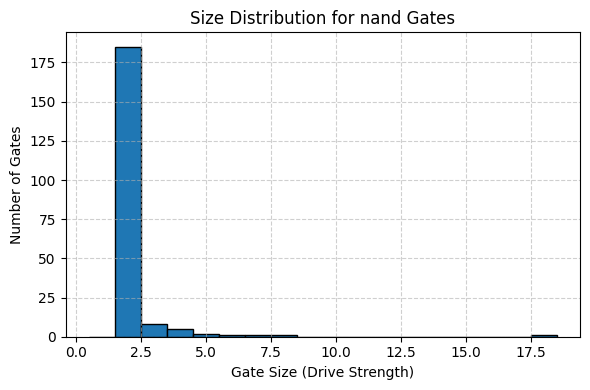

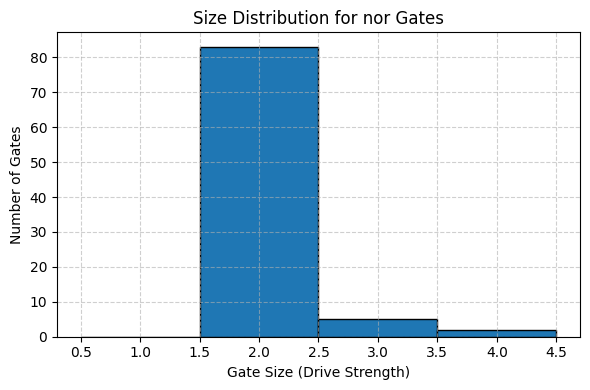

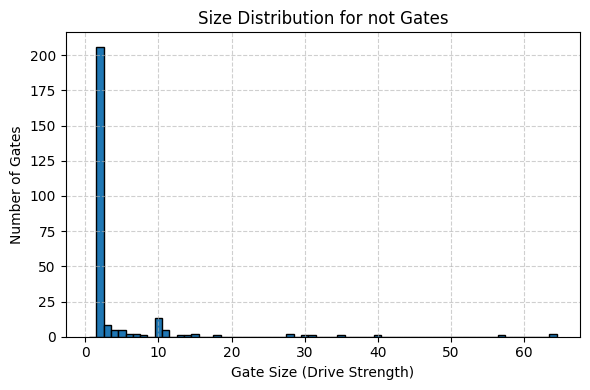

{'cost': 1305.52,
 'cost function': gpkit.Posynomial(x[:].sum()),
 'freevariables': {x[:]: array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         17.87178121,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.79272104,
          4.052415  ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.08385439,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  

In [101]:
optimize_and_plot_histogram(parser, Tmax_val)